# Modelo de DEEP LEARNING baseado na memória de curto prazo - LSTM

## 1. Bibliotecas

In [1]:
import math
import numpy                  as np
import pandas                 as pd
import yfinance               as yf

import matplotlib.pyplot      as plt

from datetime                 import datetime
from datetime                 import timedelta

from sklearn.preprocessing    import MinMaxScaler

from keras.models             import Sequential
from keras.layers             import Dense, LSTM

## 2. Ativo de interesse

In [2]:
acao = 'CMIN3.SA'

inicio = '2014-12-31'
final  = '2023-05-26'

dados_acao = yf.download(acao, inicio, final)

dados_acao

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-22,8.92,9.30,8.67,9.29,6.453815,10507000
2021-02-23,9.50,9.60,9.10,9.12,6.335714,9243700
2021-02-24,9.16,9.28,9.07,9.15,6.356556,6550600
2021-02-25,9.18,9.29,9.00,9.05,6.287085,6054200
2021-02-26,9.15,9.17,8.90,8.93,6.203722,4849000
...,...,...,...,...,...,...
2023-05-19,4.75,4.99,4.71,4.90,4.900000,12159300
2023-05-22,4.90,4.98,4.76,4.78,4.780000,8267800
2023-05-23,4.75,4.76,4.65,4.67,4.670000,7858700


In [3]:
# Selecionaremos o valor de fechamento 'Close', ao invés da cotação ajustada 'Adj Close' (mais comunmente encontrada
# nos modelos de financças), pois precisamos de uma cotação real;

cotacao = dados_acao['Close'].to_numpy().reshape(-1, 1) # reescalando os dados com o numpy
cotacao

array([[ 9.28999996],
       [ 9.11999989],
       [ 9.14999962],
       [ 9.05000019],
       [ 8.93000031],
       [ 8.94999981],
       [ 8.80000019],
       [ 8.48999977],
       [ 8.44999981],
       [ 8.51000023],
       [ 8.51000023],
       [ 8.47000027],
       [ 8.39000034],
       [ 8.5       ],
       [ 8.48999977],
       [ 8.48999977],
       [ 8.5       ],
       [ 8.61999989],
       [ 8.48999977],
       [ 8.52999973],
       [ 8.39999962],
       [ 8.31999969],
       [ 8.35999966],
       [ 8.30000019],
       [ 8.35999966],
       [ 9.17000008],
       [ 9.02000046],
       [ 9.18999958],
       [ 9.05000019],
       [ 9.19999981],
       [ 9.25      ],
       [ 9.38000011],
       [ 9.30000019],
       [ 9.36999989],
       [ 9.43000031],
       [ 9.38000011],
       [ 9.47000027],
       [ 9.68999958],
       [ 9.56999969],
       [ 9.72000027],
       [ 9.65999985],
       [ 9.65999985],
       [ 9.75      ],
       [ 9.92000008],
       [10.25      ],
       [10

In [4]:
tamanho_dados_treinamento = int(len(cotacao) * 0.8)

tamanho_dados_treinamento

451

## 3. Separando os dados em treino e teste

In [5]:
# Escalar os dados entre 0 e 1

escalador = MinMaxScaler(feature_range=(0, 1))

dados_entre_0_e_1_treinamento = escalador.fit_transform(cotacao[0:tamanho_dados_treinamento, :])

dados_entre_0_e_1_teste = escalador.transform(cotacao[tamanho_dados_treinamento: , :])

dados_entre_0_e_1 = list(dados_entre_0_e_1_treinamento.reshape(
    len(dados_entre_0_e_1_treinamento))) + list(dados_entre_0_e_1_teste.reshape(len(dados_entre_0_e_1_teste)))

dados_entre_0_e_1 = np.array(dados_entre_0_e_1).reshape(len(dados_entre_0_e_1), 1)

dados_entre_0_e_1

array([[0.7900913 ],
       [0.76792701],
       [0.77183832],
       [0.75880058],
       [0.74315523],
       [0.74576272],
       [0.72620606],
       [0.68578879],
       [0.68057367],
       [0.68839641],
       [0.68839641],
       [0.68318129],
       [0.67275106],
       [0.6870926 ],
       [0.68578879],
       [0.68578879],
       [0.6870926 ],
       [0.70273796],
       [0.68578879],
       [0.69100391],
       [0.67405474],
       [0.6636245 ],
       [0.66883962],
       [0.66101701],
       [0.66883962],
       [0.77444594],
       [0.75488928],
       [0.77705344],
       [0.75880058],
       [0.77835725],
       [0.78487618],
       [0.80182535],
       [0.79139511],
       [0.80052154],
       [0.80834428],
       [0.80182535],
       [0.8135594 ],
       [0.84224249],
       [0.82659713],
       [0.84615392],
       [0.83833118],
       [0.83833118],
       [0.85006523],
       [0.87222952],
       [0.91525428],
       [0.96870929],
       [0.98696226],
       [0.946

In [6]:
dados_para_treinamento = dados_entre_0_e_1[0: tamanho_dados_treinamento, :]

# dados usados para gerar o resultado
treinamento_x = []

# cotação real
treinamento_y = []

for i in range(60, len(dados_para_treinamento)):
    
    # 60 últimos dias
    treinamento_x.append(dados_para_treinamento[i - 60: i, 0])
    
    # cotação real
    treinamento_y.append(dados_para_treinamento[i, 0])
    
    if i <= 61:
        print(treinamento_x)
        print(treinamento_y)


[array([0.7900913 , 0.76792701, 0.77183832, 0.75880058, 0.74315523,
       0.74576272, 0.72620606, 0.68578879, 0.68057367, 0.68839641,
       0.68839641, 0.68318129, 0.67275106, 0.6870926 , 0.68578879,
       0.68578879, 0.6870926 , 0.70273796, 0.68578879, 0.69100391,
       0.67405474, 0.6636245 , 0.66883962, 0.66101701, 0.66883962,
       0.77444594, 0.75488928, 0.77705344, 0.75880058, 0.77835725,
       0.78487618, 0.80182535, 0.79139511, 0.80052154, 0.80834428,
       0.80182535, 0.8135594 , 0.84224249, 0.82659713, 0.84615392,
       0.83833118, 0.83833118, 0.85006523, 0.87222952, 0.91525428,
       0.96870929, 0.98696226, 0.946545  , 0.90743154, 0.89830511,
       0.89569762, 0.94784881, 0.96349417, 0.96349417, 1.        ,
       0.88787488, 0.86571059, 0.82268582, 0.83702737, 0.85267285])]
[0.8057366559414565]
[array([0.7900913 , 0.76792701, 0.77183832, 0.75880058, 0.74315523,
       0.74576272, 0.72620606, 0.68578879, 0.68057367, 0.68839641,
       0.68839641, 0.68318129, 0.6727

In [7]:
# Transformando as listas em arrays e dando um reshape, pois o modelo necessida dos dados em 3 Dimensões

treinamento_x, treinamento_y = np.array(treinamento_x), np.array(treinamento_y)
treinamento_x = treinamento_x.reshape(treinamento_x.shape[0], treinamento_x.shape[1], 1)
treinamento_x

array([[[0.7900913 ],
        [0.76792701],
        [0.77183832],
        ...,
        [0.82268582],
        [0.83702737],
        [0.85267285]],

       [[0.76792701],
        [0.77183832],
        [0.75880058],
        ...,
        [0.83702737],
        [0.85267285],
        [0.80573666]],

       [[0.77183832],
        [0.75880058],
        [0.74315523],
        ...,
        [0.85267285],
        [0.80573666],
        [0.79661023]],

       ...,

       [[0.06649283],
        [0.07040417],
        [0.05736637],
        ...,
        [0.07561929],
        [0.07431551],
        [0.07561929]],

       [[0.07040417],
        [0.05736637],
        [0.04823988],
        ...,
        [0.07431551],
        [0.07561929],
        [0.06910039]],

       [[0.05736637],
        [0.04823988],
        [0.0404172 ],
        ...,
        [0.07561929],
        [0.06910039],
        [0.06127771]]])

## 4.0 Modelo

In [8]:
modelo = Sequential()

# Modelo com 50 neurônios;
# return sequences = True pois usaremos outro LSTM depois;
# definir o shape, que no caso são 60 informações para gerar um valor;
# adicionar mais neurônios com o dense de 25 e 1

modelo.add(LSTM(50, return_sequences=True, input_shape = (treinamento_x.shape[1], 1))) # Modelo de 50 neurônios + return_sequences = True para adicionar mais 50 neurônios
modelo.add(LSTM(50, return_sequences=False))
modelo.add(Dense(25))
modelo.add(Dense(1))

treinamento_x.shape[1]

60

In [9]:
# Copilando o modelo

# A função de Loss é a forma de medir o ERRO do modelo, que nesse caso é classificado como o Erro Médio Quadrátrico que é
# usado na Regresão Linear

modelo.compile(optimizer = 'adam', loss='mean_squared_error')

In [10]:
# Agora com o modelo copilado e os dados, treinaremos o modelo
# batch size -> neste caso o modelo irá otimizar os parâmetros a cada novo dado
# epochs -> quantas vezes o algoritmo irá rodar os dados de treinamento

modelo.fit(treinamento_x, treinamento_y, batch_size=1, epochs=1)

391/391 [==============================] - 19s 33ms/step - loss: 0.0055


### 4.1 Modelo de teste

In [11]:
dados_teste = dados_entre_0_e_1[tamanho_dados_treinamento - 60:, :]

teste_x = []
teste_y = cotacao[tamanho_dados_treinamento: , :]

for i in range(60, len(dados_teste)):
    teste_x.append(dados_teste[i - 60: i, 0])

In [12]:
# reshape

teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

### 4.2 Predições do Modelo

In [13]:
predicoes = modelo.predict(teste_x)

# Tirando a escala dos dados
predicoes = escalador.inverse_transform(predicoes)

predicoes

4/4 [==============================] - 2s 27ms/step


array([[3.639166 ],
       [3.6557348],
       [3.6663923],
       [3.6777177],
       [3.6870754],
       [3.6934319],
       [3.697476 ],
       [3.7067938],
       [3.7178674],
       [3.7328684],
       [3.7512028],
       [3.770498 ],
       [3.7920506],
       [3.8154135],
       [3.836677 ],
       [3.8528526],
       [3.8617766],
       [3.8649004],
       [3.868267 ],
       [3.8863366],
       [3.9105682],
       [3.9536312],
       [4.004901 ],
       [4.0586014],
       [4.113182 ],
       [4.154643 ],
       [4.192582 ],
       [4.2377114],
       [4.282922 ],
       [4.3265357],
       [4.377064 ],
       [4.4348044],
       [4.5024614],
       [4.575706 ],
       [4.642956 ],
       [4.7031655],
       [4.7657957],
       [4.8259735],
       [4.857864 ],
       [4.869204 ],
       [4.8644648],
       [4.851323 ],
       [4.83705  ],
       [4.8179035],
       [4.7977757],
       [4.774305 ],
       [4.7467756],
       [4.7335553],
       [4.7231836],
       [4.715955 ],


### 4.3 Erro Médio Quadrático

In [14]:
rmse = np.sqrt(np.mean(predicoes - teste_y) ** 2)
rmse

0.22837231855476853

In [15]:
# Criando o gráfico do modelo

treinamento = dados_acao.iloc[:tamanho_dados_treinamento, :]
df_teste = pd.DataFrame({'Close': dados_acao['Close'].iloc[tamanho_dados_treinamento:],
                        'predicoes': predicoes.reshape(len(predicoes))})

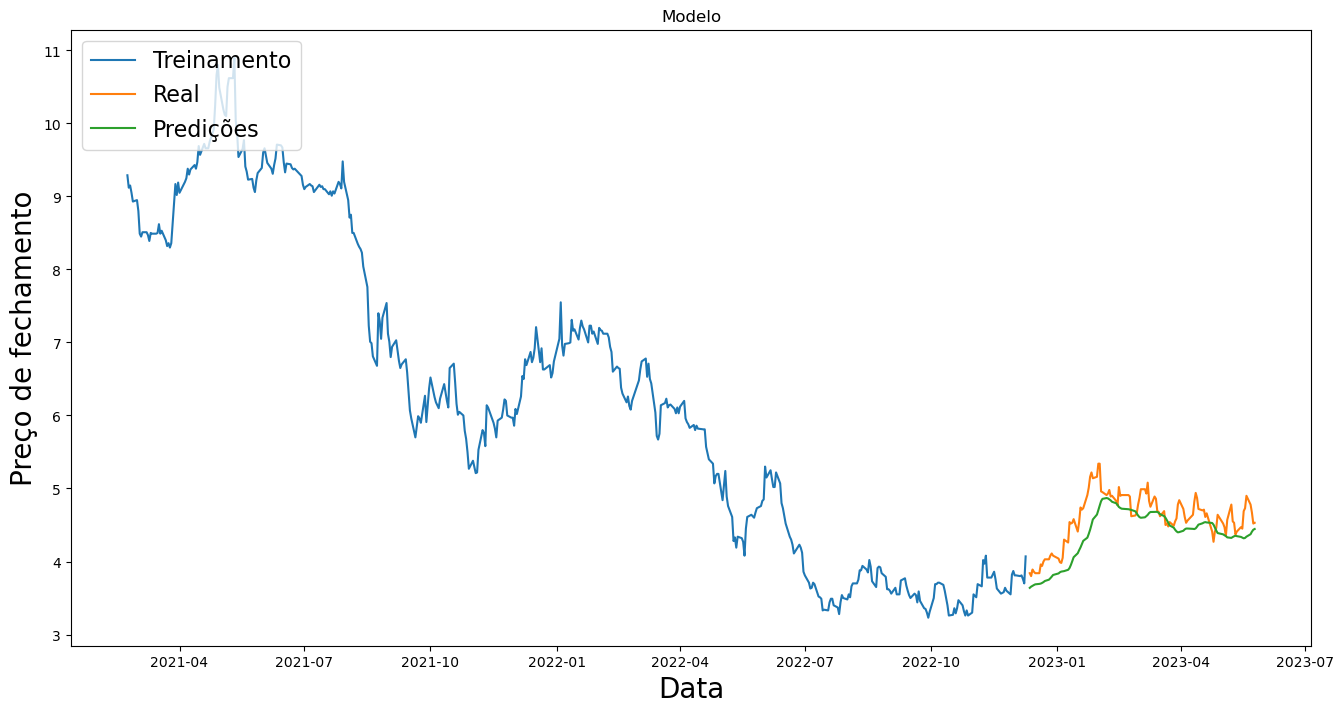

In [16]:
# Gerando o gráfico

plt.figure(figsize = (16, 8))
plt.title('Modelo')
plt.xlabel('Data', fontsize = 20)
plt.ylabel('Preço de fechamento', fontsize = 20)
plt.plot(treinamento['Close'])
plt.plot(df_teste[['Close', 'predicoes']])
plt.legend(['Treinamento', 'Real', 'Predições'], loc = 2, prop={'size': '16'})
plt.show()

In [17]:
df_teste.sort_index()

df_teste

,Close,predicoes
Date,,
2022-12-12,3.84,3.639166
2022-12-13,3.80,3.655735
2022-12-14,3.89,3.666392
2022-12-15,3.86,3.677718
2022-12-16,3.84,3.687075
...,...,...
2023-05-19,4.90,4.340065
2023-05-22,4.78,4.373656
2023-05-23,4.67,4.408382


### 4.4 Avaliando a acertividade do modelo em prever o direcionamento do ativo

In [18]:
df_teste['variacao_percentual_acao'] = df_teste['Close'].pct_change()
df_teste['variacao_percentual_modelo'] = df_teste['predicoes'].pct_change()

df_teste = df_teste.dropna()

df_teste['var_acao_maior_menor_que_zero'] = np.where(df_teste['variacao_percentual_acao'] > 0, True, False)
df_teste['var_modelo_maior_menor_que_zero'] = np.where(df_teste['variacao_percentual_modelo'] > 0, True, False)

df_teste['acertou_o_lado'] = np.where(df_teste['var_acao_maior_menor_que_zero'] == df_teste['var_modelo_maior_menor_que_zero'], True, False)
df_teste['variacao_percentual_acao_abs'] = df_teste['variacao_percentual_acao'].abs()
df_teste

C:\Users\d311r.DESKTOP-O2NL7MH\AppData\Local\Temp\ipykernel_16988\2237842766.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste['var_acao_maior_menor_que_zero'] = np.where(df_teste['variacao_percentual_acao'] > 0, True, False)
C:\Users\d311r.DESKTOP-O2NL7MH\AppData\Local\Temp\ipykernel_16988\2237842766.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste['var_modelo_maior_menor_que_zero'] = np.where(df_teste['variacao_percentual_modelo'] > 0, True, False)
C:\Users\d311r.DESKTOP-O2NL7MH\App

,Close,predicoes,variacao_percentual_acao,variacao_percentual_modelo,var_acao_maior_menor_que_zero,var_modelo_maior_menor_que_zero,acertou_o_lado,variacao_percentual_acao_abs
Date,,,,,,,,
2022-12-13,3.80,3.655735,-0.010417,0.004553,False,True,False,0.010417
2022-12-14,3.89,3.666392,0.023684,0.002915,True,True,True,0.023684
2022-12-15,3.86,3.677718,-0.007712,0.003089,False,True,False,0.007712
2022-12-16,3.84,3.687075,-0.005181,0.002544,False,True,False,0.005181
2022-12-19,3.84,3.693432,0.000000,0.001724,False,True,False,0.000000
...,...,...,...,...,...,...,...,...
2023-05-19,4.90,4.340065,0.035941,0.003958,True,True,True,0.035941
2023-05-22,4.78,4.373656,-0.024490,0.007740,False,True,False,0.024490
2023-05-23,4.67,4.408382,-0.023013,0.007940,False,True,False,0.023013


In [19]:
acertou_lado = df_teste['acertou_o_lado'].sum()/len(df_teste['acertou_o_lado'])
errou_lado = 1 - acertou_lado

media_lucro = df_teste.groupby('acertou_o_lado')['variacao_percentual_acao_abs'].mean()

exp_mat_lucro = acertou_lado * media_lucro[1] - media_lucro[0] * errou_lado

ganho_sobre_perda = media_lucro[1]/media_lucro[0]

print(f'O lucro médio foi de \n{media_lucro.round(4)}')
print(f'A relação de Lucro/Perda foi de {ganho_sobre_perda.round(4)}')
print(f'O percentual de acerto do lado foi de {acertou_lado.round(4)*100}%')
print(f'Expectativa de ganho por dia {exp_mat_lucro.round(4)*100}%')

O lucro médio foi de 
acertou_o_lado
False    0.0183
True     0.0212
Name: variacao_percentual_acao_abs, dtype: float64
A relação de Lucro/Perda foi de 1.1576
O percentual de acerto do lado foi de 42.86%
Expectativa de ganho por dia -0.13999999999999999%


### 4.5 Gerando previsão de direção do ativo

In [20]:
data_hoje = datetime.now()

if data_hoje.hour > 18: # verificando se o mercado está aberto ou já fechou
    final = data_hoje
    inicial = datetime.now() - timedelta(days = 252)
    
else:
    final = data_hoje - timedelta(days = 1)
    inicial = datetime.now() - timedelta(days = 252)


cotacoes = yf.download(acao, inicial, final)
ultimos_60_dias = cotacoes['Close'].iloc[-60:].values.reshape(-1, 1)

ultimos_60_dias_escalado = escalador.transform(ultimos_60_dias)

teste_x = []
teste_x.append(ultimos_60_dias_escalado)
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

previsao_de_preco = modelo.predict(teste_x)
previsao_de_preco = escalador.inverse_transform(previsao_de_preco)

print(f'O modelo prevê o preço para o ativo {acao} de {previsao_de_preco}')

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 136ms/step
O modelo prevê o preço para o ativo CMIN3.SA de [[4.4411135]]
